次は、金融市場でありがちな戦略に基づいて売買して、その成績に応じて戦略をまねさせる、バージョンを作りたい

### 前提条件

・対数正規分布に従うような企業価値の変動

・企業価値に比例した「均衡」株価

・採用する戦略の種類は、同時に一種類のみ

・採用する戦略内で、パラメータ調整。パラメータは独自に振動しつつ、収益率の高いエージェントの真似をする傾向も加える

・預金×レバレッジが、買うための資金源

・いずれの戦略でも、ポートフォリオ配分割合目標を持つ

・配当（企業価値の一定割合）と税（利益の一定割合）と非金融所得（外生的、一定、全エージェント）の導入


### 戦略（案）

・ファンダメンタルズに応じて売買する。長期的戦略。

・テクニカル分析に応じて売買する。短期的戦略。

・テクニカル分析に応じて売買する。長期的戦略。


In [1]:
using StatsPlots
using Random
using Statistics

In [2]:
mutable struct Agent
    strategy::String
    money::Float64
    sharesQuantity  #   株式保有部数リスト
    sharesRetainedLine  #   株式保有金額のリスト
    total_assets_log    #   資産総額の履歴
    params  #   パラメータのリスト  
    #   ファンダメンタルズ戦略をとる場合 [ポートフォリオに占める預金の割合の目標, 企業評価/時価総額　の、買いの閾値になる倍率, 企業価値/時価総額　の、売りの閾値になる倍率, ポートフォリオ分散度合い(1以上。大きい値の時ほど分散させる)]
    #   インデックス戦略をとる場合      [ポートフォリオに占める預金の割合の目標, 1期のタイムスケール, α5, α4, α3, α2, α1, α0, β1, β2, γ, ポートフォリオ分散度合い(1以上。大きい値の時ほど分散させる)]
    fundamentals    #   企業評価のリスト    ファンダメンタルズ戦略をとる場合しか使わないが、更新はインデックス戦略をとるときでも続ける
    portfolio_target#   ポートフォリオ配分目標。[預金,株式]
    purchase_cost
    performance::Float64    #   運用成績
end
mutable struct Firm
    stockPrice::Float64     #   株価
    stockQuantity::Float64  #   株式発行部数
    stockPriceLog   #   価格の記録
    stockQuantityLog    #   発行部数の記録
    marketCapitalization::Float64   #   時価総額
    hiddenCorporateValue::Float64   #   企業価値
    buy_offers  #   買い注文 [(価格(float), 量(float), (エージェントインデックス(integer)),,,,,]
    sell_offers #   売り注文 [(価格(float), 量(float), (エージェントインデックス(integer)),,,,,]
end
function update_hiddenCorporateValue(firms, ft)
    σ_r, σ, μ = 0.02, 2.0, log(100.0*ft)
    σ_p = sqrt(σ^2 + σ_r^2)
    for firm in firms
        f = firm.hiddenCorporateValue
        firm.hiddenCorporateValue = exp((log(f) + σ_r*randn())*σ/σ_p + μ*(1 - σ/σ_p))
    end
end
function update_estimate_corporateValue(agents, firms)
    for agent in agents
        for (i, estimated_value) in enumerate(agent.fundamentals)
            agent.fundamentals[i] = (0.02*firms[i].hiddenCorporateValue + 0.98*estimated_value) * exp(0.1*randn())
        end
    end
end
function update_portfolio_target(agents)
    for agent in agents
        if agent.total_assets_log[end] <= 0
            agent.portfolio_target[1:2] = [0,0]
            continue
        end
        agent.portfolio_target[1] = agent.total_assets_log[end] * agent.params[1]
        agent.portfolio_target[2] = agent.total_assets_log[end] * (1 - agent.params[1])
    end
end
function cal_total_asset(agents)
    for agent in agents
        push!(agent.total_assets_log, sum(agent.sharesRetainedLine) + agent.money)
    end
end
function cal_sharesRetainedLine(agents, firms)
    for agent in agents
        for i = 1:size(agent.sharesQuantity)[1]
            agent.sharesRetainedLine[i] = firms[i].stockPrice*agent.sharesQuantity[i]
        end
    end
end
function fundamentals_trade_offer(agent, firms, j)
    lst = []
    marketCap, mean_ln_amp, fundamentals_sum = 0.0, 0.0, 0.0
    for (i, firm) in enumerate(firms)
        marketCap = firm.marketCapitalization
        fundamentals = agent.fundamentals[i]
        push!(lst, (marketCap/fundamentals, i))    #   marketCap/fundamentalsが小さいほど買いたい、大きいほど売りたい
        mean_ln_amp += log(marketCap/fundamentals)
        fundamentals_sum += fundamentals
    end
    mean_ln_amp /= size(firms)[1]
    sort!(lst)
    sell, buy = [], []
    #   全部売り候補に入れて、ポートフォリオ配分目標に至るまで買い候補に入れて、その差額を本チャンの売買リストに加える
    #   すべて仮売り。
    for (i,q) in enumerate(agent.sharesQuantity)
        if q > 0.0
            p = min(firms[i].stockPrice, (0.2*exp(mean_ln_amp)*agent.fundamentals[i] + 0.8*firms[i].marketCapitalization)/(firms[i].stockQuantity))
            push!(sell, (i, p, q))
        end
    end
    #   仮買い。
    allocations_lst = [0.0 for _ = 1:size(firms)[1]]
    for k in 1:min(Integer(agent.params[end]), size(firms)[1])
        _, i = lst[k]
        allocations_lst[i] = agent.portfolio_target[2]*agent.fundamentals[i]/fundamentals_sum
    end
    for k in 1:min(Integer(agent.params[end]), size(firms)[1])
        _, i = lst[k]
        p = (0.2*exp(mean_ln_amp)*agent.fundamentals[i] + 0.8*firms[i].marketCapitalization)/(firms[i].stockQuantity)
        q = allocations_lst[i]/p
        push!(buy, (i, p, q))
    end
    #   注文の決定
    going_to_buy_price = 0.0
    for (ib, pb, qb) in sell
        q, p = qb, pb
        for (is, ps, qs) in buy
            if ib == is
                q -= qs
                if q < 0.0
                    p = ps
                end
                break
            end
        end
        if q > 0
            push!(firms[ib].sell_offers, (p, q, j))
        elseif q < 0
            going_to_buy_price += p*(-q)
            if going_to_buy_price > agent.money
                continue
            end
            push!(firms[ib].buy_offers, (p, -q, j))
        end
    end
end
function chart_trade_offer(agent, firms, j)
    span = agent.params[2]
    if size(firms[1].stockPriceLog)[1] < span*6
        return nothing
    end
    α5, α4, α3, α2, α1 = agent.params[3:7]
    α0 = agent.params[8]
    β1, β2 = agent.params[9:10]                #   β1<β2 の条件を追加する
    sell, buy = [], []
    for (i, firm) in enumerate(firms)
        x1, x2, x3, x4, x5, x6 = firm.stockPriceLog[end-5:end]
        p = α0 + α1*(x2-x1)/x1 + α2*(x3-x2)/x2 + α3*(x4-x3)/x3 + α4*(x5-x4)/x4 + α5*(x6-x5)/x5
        if p > β2
            push!(buy, (p,i))
        end
    end
    for (i, q) in enumerate(agent.sharesQuantity)
        if q == 0.0
            continue
        end
        x1, x2, x3, x4, x5, x6 = firms[i].stockPriceLog[end-5:end]
        p = α0 + α1*(x2-x1)/x1 + α2*(x3-x2)/x2 + α3*(x4-x3)/x3 + α4*(x5-x4)/x4 + α5*(x6-x5)/x5
        if p < β1
            push!(sell, (p,i))
        end
    end
    #   売り
    going_to_sell_price = 0.0
    for (p, i) in sell
        price = (1+p)*firms[i].stockPrice
        quantity = agent.sharesQuantity[i]
        if price <= 0.0 || quantity == 0.0
            continue
        end
        going_to_sell_price += price * quantity
        push!(firms[i].sell_offers, (price, quantity, j))
    end
    #   買い
    sort!(buy)
    if size(buy)[1] > Integer(agent.params[end])
        buy = buy[end-Integer(agent.params[end])+1:end]
    end
    marketCap_sum = 0
    for (_, i) in buy
        marketCap_sum += firms[i].marketCapitalization
    end
    allocations_lst = [0.0 for _ = 1:size(firms)[1]]
    buy_target = max(0.0, agent.money + going_to_sell_price - agent.portfolio_target[1])
    if buy_target == 0.0
        return nothing
    end
    for k in 1:min(Integer(agent.params[end]), size(buy)[1])
        _, i = buy[k]
        allocations_lst[i] = buy_target*firms[i].marketCapitalization/marketCap_sum
    end
    for (p, i) in buy
        price = (1+p)*firms[i].stockPrice
        if price <= 0.0
            continue
        end
        quantity = allocations_lst[i]/price
        push!(firms[i].buy_offers, (price, quantity, j))
    end
end
function trade_offer(agents, firms)
    for firm in firms
        firm.buy_offers, firm.sell_offers = [], []
    end
    for (j, agent) in enumerate(agents)
        if agent.strategy == "fundamentals"
            fundamentals_trade_offer(agent, firms, j)
        elseif agent.strategy == "chart"
            chart_trade_offer(agent, firms, j)
        end
    end
end
function cal_performance(agents, income)
    for agent in agents
        agent.performance = (agent.total_assets_log[end] - agent.total_assets_log[end-1] - income)/agent.total_assets_log[end-1]
    end
end
function trade_matching(agents, firms)
    for (i, firm) in enumerate(firms)
        buy, sell = firm.buy_offers, firm.sell_offers
        sort!(buy)
        sort!(sell, rev=true)
        selling_p, selling_q, buying_p, buying_q = 0.0, 0.0, 0.0, 0.0
        trading_p = firm.stockPrice
        pb, qb, jb, ps, qs, js = 0.0, 0.0, -1, 0.0, 0.0, -1
        while buying_p >= selling_p
            if size(buy)[1] == 0 || size(sell)[1] == 0
                break
            end
            if buying_q == 0.0
                pb, qb, jb = pop!(buy)
                buying_q = qb
                buying_p = pb
            end
            if selling_q == 0.0
                ps, qs, js = pop!(sell)
                selling_q = qs
                selling_p = ps
            end
            if buying_p < selling_p
                break
            end
            trading_q = min(buying_q, selling_q)
            buying_q -= trading_q
            selling_q -= trading_q
            trading_p = (pb + ps)/2
            agents[jb].purchase_cost[i] = (agents[jb].purchase_cost[i]*agents[jb].sharesQuantity[i] + trading_p*trading_q)/(agents[jb].sharesQuantity[i] + trading_q)
            agents[jb].sharesQuantity[i] += trading_q
            agents[js].sharesQuantity[i] -= trading_q
            agents[jb].money -= trading_p*trading_q
            tax, tax_rate = 0.0, 0.2
            if agents[js].purchase_cost[i] < trading_p
                tax = tax_rate*trading_q*(trading_p - agents[js].purchase_cost[i])
            end
            agents[js].money += trading_p*trading_q - tax
        end
        firm.stockPrice = trading_p
        push!(firm.stockPriceLog, trading_p)
    end
end
function update_strategy(agents)
    if size(agents[1].total_assets_log)[1] < 10
        return nothing
    end
    A = Integer(size(agents)[1])
    for agent in agents
        teacher = rand(1:A)
        t0, t1 = agent.total_assets_log[end-9], agent.total_assets_log[end]
        if rand() < 0.01 - 0.01*(t1 - t0)/t0
            new_strategy = deepcopy(agents[teacher].strategy)
            agent.strategy = new_strategy
            new_params = append!([agent.params[1]], agents[teacher].params[2:end])
            agent.params = new_params
        end
    end
end
function update_params(agents)
    for agent in agents
        agent.params[1] += 0.01*randn()
        agent.params[1] = abs(agent.params[1])
        if agent.params[1] > 1
            agent.params[1] = 1 - agent.params[1] % 1
        end
        agent.params[end] += rand(-1:1)
        if agent.params[end] <= 0
            agent.params[end] = 1
        end
        if agent.strategy == "chart"
            if rand() < 0.01
                agent.params[2] += rand(-1:1) #   タイムスケール
                if agent.params[2] <= 0
                    agent.params[2] = 1
                end
            end
            agent.params[3:7] += 0.01*randn(5)
            agent.params[3:7] = (agent.params[3:7] .- sum(agent.params[3:7])/5)/(std(agent.params[3:7])*sqrt(5))
            agent.params[8] += 0.01*randn()
            agent.params[9:10] += 0.01*randn(2)
            if agent.params[9] > agent.params[10]
                agent.params[9], agent.params[10] = agent.params[10], agent.params[9]
            end
            agent.params[11] += 0.01*randn()
            if agent.params[11] < 0
                agent.params[11] = abs(agent.params[11] % 1)
            elseif agent.params[11] > 1
                agent.params[11] = 1 - agent.params[11] % 1
            end
        end
    end
end
function update_marketCapitalization(firms)
    for firm in firms
        firm.marketCapitalization = firm.stockPrice*firm.stockQuantity
    end
end
function get_income(agents, income)
    for agent in agents
        agent.money += income
    end
end
function get_dividend(agents, firms)
    Π = 0.2
    payout_ratio = 0.35
    for agent in agents
        for (i, q) in enumerate(agent.sharesQuantity)
            if q > 0.0
                dividend = q/firms[i].stockQuantity * Π*payout_ratio*firms[i].hiddenCorporateValue
                agent.money += dividend
            end
        end
    end
end
function run_one_term(agents, firms, income, ft)
    update_hiddenCorporateValue(firms, ft)
    update_estimate_corporateValue(agents, firms)
    trade_offer(agents, firms)
    trade_matching(agents, firms)
    get_dividend(agents, firms)
    cal_sharesRetainedLine(agents, firms)
    cal_total_asset(agents)
    cal_performance(agents, income)
    get_income(agents, income)
    update_strategy(agents)
    update_params(agents)
    update_portfolio_target(agents)
    update_marketCapitalization(firms)
end
function f(t)
    return 2^(0.01*t)
end

f (generic function with 1 method)

In [3]:
N, M = 10^3, 10^1 #   エージェント数, 株式会社数
init_stock_quantity, init_stock_price = 100.0, 1.0
init_money = init_stock_quantity*init_stock_price*M/N * 9.0
agents = [
    Agent(
        "chart",
        init_money,
        [init_stock_quantity/N for _ = 1:M],
        [init_stock_quantity*init_stock_price/N for _ = 1:M],
        [init_money/0.9],
        [0.9, 1, randn(), randn(), randn(), randn(), randn(), 0.0, -0.01, 0.01, 0.5, 5],
        [init_money*N/M for _ = 1:M],
        [init_money, 0.1*init_money],
        [1.0 for _ = 1:M],
        0.0,
    ) for j = 1:Int(floor(N/2))
]
for _ = 1:(N - Int(floor(N/2)))
    push!(agents, 
        Agent(
            "fundamentals",
            init_money,
            [init_stock_quantity/N for _ = 1:M],
            [init_stock_quantity*init_stock_price/N for _ = 1:M],
            [init_money/0.9],
            [0.9, 5],
            [init_money*N/M for _ = 1:M],
            [init_money, 0.1*init_money],
            [1.0 for _ = 1:M],
            0.0
        )
    )
end
firms = [
    Firm(
        init_stock_price,
        init_stock_quantity,
        [init_stock_price],
        [init_stock_quantity],
        init_stock_price*init_stock_quantity,
        init_stock_price*init_stock_quantity,
        [],
        [],
    ) for _ = 1:M
];

In [4]:
money_sum = 0.0
for agent in agents
    money_sum += agent.money
end
money_sum

9000.0

In [5]:
T = 10^3
income_lst = [0.0002*init_money*f(t) for t = 1:T] 
#   income=constantだと、金融市場の規模が継続的に大きく（小さく）ならないためか、
#   適応の結果ポートフォリオ配分目標に占める預金の割合がとても大きくなる。そして売買が減り、値動きが激減する
@time for t = 1:T
    income = income_lst[t]
    run_one_term(agents, firms, income, f(t))
end

 85.136980 seconds (846.16 M allocations: 18.868 GiB, 5.22% gc time, 3.07% compilation time)


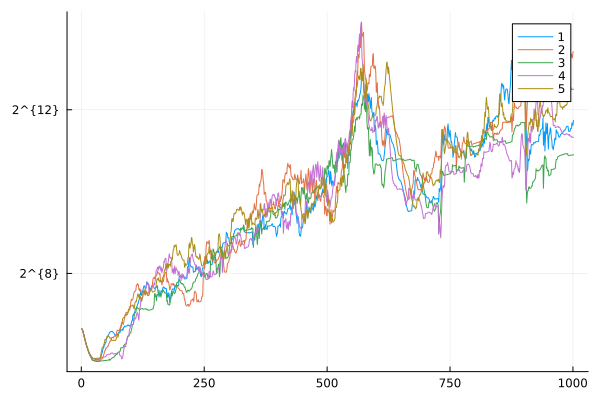

In [6]:
plot(firms[1].stockPriceLog.*firms[1].stockQuantityLog, label="1", yscale=:log2)
for i = 2:4
    plot!(firms[i].stockPriceLog.*firms[i].stockQuantityLog, label=string(i), yscale=:log2)
end
plot!(firms[5].stockPriceLog.*firms[5].stockQuantityLog, label=string(5), yscale=:log2)

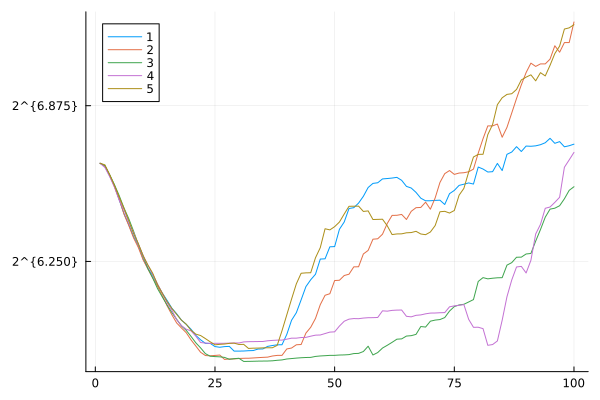

In [7]:
plot(firms[1].stockPriceLog[1:100].*firms[1].stockQuantityLog, label="1", yscale=:log2)
for i = 2:4
    plot!(firms[i].stockPriceLog[1:100].*firms[i].stockQuantityLog, label=string(i), yscale=:log2)
end
plot!(firms[5].stockPriceLog[1:100].*firms[5].stockQuantityLog, label=string(5), yscale=:log2)

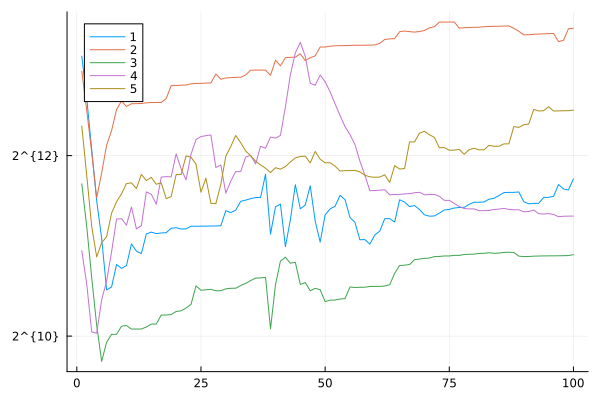

In [8]:
plot(firms[1].stockPriceLog[end-99:end].*firms[1].stockQuantityLog, label="1", yscale=:log2)
for i = 2:4
    plot!(firms[i].stockPriceLog[end-99:end].*firms[1].stockQuantityLog, label=string(i), yscale=:log2)
end
plot!(firms[5].stockPriceLog[end-99:end].*firms[1].stockQuantityLog, label=string(5), yscale=:log2)

・企業価値/時価総額が相対的に大きいときは、fundamental戦略をとるエージェントが売買の中心になっていて、価格変動が安定しやすい

・企業価値/時価総額が相対的に小さいときは、chart戦略をとるエージェントが売買の中心になっていて、価格変動が変動しやすい

かもしれない

In [9]:
tmp = 0.0
for i = 1:10
    for t = 1:99
        tmp += 100*(firms[i].stockPriceLog[end-t] - firms[i].stockPriceLog[end-1-t])/firms[i].stockPriceLog[end-1-t]
    end
    tmp /= 99
    println("「会社$i","の直近１００期の株価の平均変動率」は $tmp"," %")
end

「会社1の直近１００期の株価の平均変動率」は -0.31453816099792337 %
「会社2の直近１００期の株価の平均変動率」は 0.5662783472179733 %
「会社3の直近１００期の株価の平均変動率」は -0.11970787057060026 %
「会社4の直近１００期の株価の平均変動率」は 0.7878018292211724 %
「会社5の直近１００期の株価の平均変動率」は 0.5019325612116549 %
「会社6の直近１００期の株価の平均変動率」は -0.08124852078845897 %
「会社7の直近１００期の株価の平均変動率」は 0.3132195711218273 %
「会社8の直近１００期の株価の平均変動率」は 0.6650381998323878 %
「会社9の直近１００期の株価の平均変動率」は 1.4375205275248624 %
「会社10の直近１００期の株価の平均変動率」は 0.41873245769869427 %


In [23]:
for i = 1:10
    println(agents[i].portfolio_target[2], " / ", sum(agents[i].sharesRetainedLine))
end#    ポートフォリオ配分が目標との乖離が激しい問題。

145.14766309071612 / 144.94779327967532
239.6773817798209 / 0.0
50.64953874388423 / 0.0
91.45912766431402 / 170.63662090476706
134.4569964470704 / 214.74020989381876
15.284834030786573 / 0.0
89.29808090897838 / 141.3399370417198
248.29906535110956 / 256.78745967882855
40.90462747185317 / 0.0
74.39749107635684 / 0.0


In [11]:
agents

1000-element Vector{Agent}:
 Agent("chart", 218.8787484672162, [0.24855681686524808, 0.46364622779669956, 0.0, 0.8075646173025797, 0.6004887826579316, 0.08525443017370764, 0.0, 0.15748656045005838, 0.0, 0.1877874993200148], [8.521860933916217, 50.56363471998309, 0.0, 20.79616247393686, 34.88404543868918, 6.084956712134304, 0.0, 13.676364444671412, 0.0, 10.420768556344257], [10.0, 10.060567434628558, 10.106892151843915, 10.149653858408316, 10.190482306822084, 10.23101299930865, 10.291689085169747, 10.347807754241808, 10.410850613289755, 10.472196390979677  …  338.3519213370153, 343.79505980933766, 344.7335050402059, 347.06568468434716, 349.6198585542108, 352.078511001346, 350.9462049356858, 353.42743412875336, 358.25513911068833, 361.98334174689154], [0.5990211527683855, 3.0, 0.18094890695634644, 0.4529063939845445, 0.29870418154018, -0.6042571109555535, -0.32830237152551756, -0.0005908458077901642, -0.14858546321900454, -0.0004039077592426655, 0.14402789841225347, 35.0], [74.9039811631

In [12]:
firms

10-element Vector{Firm}:
 Firm(34.28536397187705, 100.0, [1.0, 0.9923126695860756, 0.965672790678068, 0.9396455972587316, 0.9032711063387053, 0.8688750071548037, 0.8427643504488114, 0.8155679128762492, 0.7954634750230959, 0.7659315068248638  …  28.289868595124055, 28.389240480755642, 28.39566294550387, 29.722006697253008, 29.734777059115586, 29.968916846923506, 32.81482036411147, 31.688880053724738, 31.479982813599698, 34.28536397187705], [100.0], 3428.5363971877046, 59.03820945187284, Any[(25.875166304641017, 0.06401728692574345, 319), (26.826621553660793, 0.009070991142238666, 430), (27.425718116094963, 0.006930717655967242, 646), (27.80068329435929, 0.01685956657273439, 462), (27.859541427937433, 0.003995940213553796, 388), (27.863460744641742, 0.027495384253355848, 212), (27.91947470929174, 0.0006131698477718009, 511), (28.124215602185167, 0.013541322209067341, 859), (28.12844966802726, 0.0044734274200847746, 613), (28.284465757310276, 0.007228471080577354, 623)  …  (32.03354651295

In [13]:
money_sum = 0.0
for agent in agents
    money_sum += agent.money
end
money_sum

327462.0639083198

In [14]:
for firm in firms[1:10]
    println(firm.hiddenCorporateValue)
end

59.03820945187284
236.7449932800652
37.44859270139076
54.72413815028347
88.14853666040797
155.18834155849098
127.97804391909104
154.68354319918305
72.42207196870858
173.77285640115446


In [15]:
for firm in firms[1:10]
    println(firm.marketCapitalization)
end

3428.5363971877046
10905.649973745569
1915.1530542324806
2575.170088976907
5809.275118226626
7137.408225867067
6024.925243209903
8684.147019013992
8041.099618399568
5549.234424058167


In [16]:
for agent in agents[1:10]
    println(agent.fundamentals)
end

[74.90398116318705, 209.24254207489963, 47.47155063117909, 58.513455286295766, 24.748031765345022, 269.5217436636565, 228.58088382079475, 135.18137288231617, 76.4551009000676, 357.97187646007865]
[101.73049255444127, 632.0393576117673, 34.752016068408636, 103.71297226003813, 165.8437003488608, 143.65047683105212, 81.38247526094626, 258.8882624059576, 53.97863398290746, 352.74767425702805]
[85.01006586138158, 97.16129186592596, 93.29415768285789, 46.92530199647854, 55.37997740930669, 134.25845708179457, 79.45552307924278, 165.9701972839958, 77.62546693472935, 484.82817277183307]
[63.72012451923816, 418.902400522941, 39.88343204591779, 56.00722465134495, 38.33186119773259, 196.23065741988864, 106.43360834159154, 216.6733133474533, 53.66133782792316, 414.3037567074792]
[25.46196859522255, 126.15688266282216, 43.37137475125831, 51.38869542372672, 79.54121377150375, 191.68085328272645, 192.13690579458967, 95.15692679653357, 63.96693487417259, 179.10292327283534]
[56.162906172873726, 91.9133

In [17]:
for agent in agents[1:10]
    println(agent.params)
end

[0.5990211527683855, 3.0, 0.18094890695634644, 0.4529063939845445, 0.29870418154018, -0.6042571109555535, -0.32830237152551756, -0.0005908458077901642, -0.14858546321900454, -0.0004039077592426655, 0.14402789841225347, 35.0]
[0.2242046098825742, 17.0]
[0.8816899759285125, 5.0, -0.4866547727421073, 0.49929108324600974, -0.04225655752302096, 0.4095576695360804, -0.37993742251696183, 0.12689451269779792, 0.4343348188165753, 0.5095405131184048, 0.38065936300160347, 6.0]
[0.7269759696160375, 5.0, -0.7319117853021637, 0.38115387693313457, 0.03784223524882652, -0.028794311367902458, 0.34170998448810513, -0.2973201894103701, -0.2797269441052014, 0.40871104727466434, 0.5183794232602122, 17.0]
[0.5978698929171231, 2.0, -0.1207690301900537, -0.7061869532067874, 0.4735256502959447, 0.172728513733496, 0.18070181936740046, 0.2392298693822993, 0.2123824916308612, 0.32727694234644067, 0.07068075880836511, 27.0]
[0.9475428959864632, 6.0, 0.06498813368031386, 0.6808206017088749, -0.49460233853510077, -0

In [18]:
for agent in agents[1:10]
    println(agent.sharesQuantity)
end

[0.24855681686524808, 0.46364622779669956, 0.0, 0.8075646173025797, 0.6004887826579316, 0.08525443017370764, 0.0, 0.15748656045005838, 0.0, 0.1877874993200148]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.01626095745249994, 0.5057123026961192, 0.10572934156268088, 0.0945410410117791, 0.0833907989494614, 0.3633666992437767, 0.1154335216692112, 0.416620001433332, 0.307251132292862, 0.21350712838084326]
[0.0, 0.09484005797654405, 0.7638857257730015, 1.0395787730088872, 0.9459382847227247, 0.05232189597089848, 0.05107742225875678, 1.0570237372795328, 0.11738849869390816, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.016293622335273664, 0.44888203957261025, 0.27733637995375054, 0.015712405533962966, 0.24148498751687675, 0.4019958530153087, 0.5713023651212685, 0.016077056317144556, 0.015759029099255892, 0.11365992524823375]
[0.14661776587373712, 0.5656800077946108, 0.5800799871725839, 0.5425553983870577, 0.4909566027868

In [19]:
for firm in firms[1:10]
    println(firm.stockQuantityLog)
end

[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
[100.0]
